In [1]:
import numpy as np
import torch

torch.manual_seed(0)

import gpytorch
import botorch

from botorch.exceptions.warnings import InputDataWarning, OptimizationWarning

import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["image.cmap"] = "magma"

import warnings

import pickle

In [2]:
from botorch.test_functions.multi_fidelity import AugmentedBranin


problem = AugmentedBranin()


def objective(X):
    X_copy = X.detach().clone()
    X_copy[..., :-1] = X_copy[..., :-1] * 15 - 5
    X_copy[..., -2] = X_copy[..., -2] + 5

    return (-problem(X_copy) / 500 + 0.9).unsqueeze(-1)


bounds = torch.tensor([[0.0] * 2, [1.0] * 2])
fidelities = torch.tensor([0.1, 0.3, 1.0])
bounds_full = torch.cat(
    [bounds, torch.tensor([fidelities.min(), fidelities.max()]).unsqueeze(-1)], dim=1
)

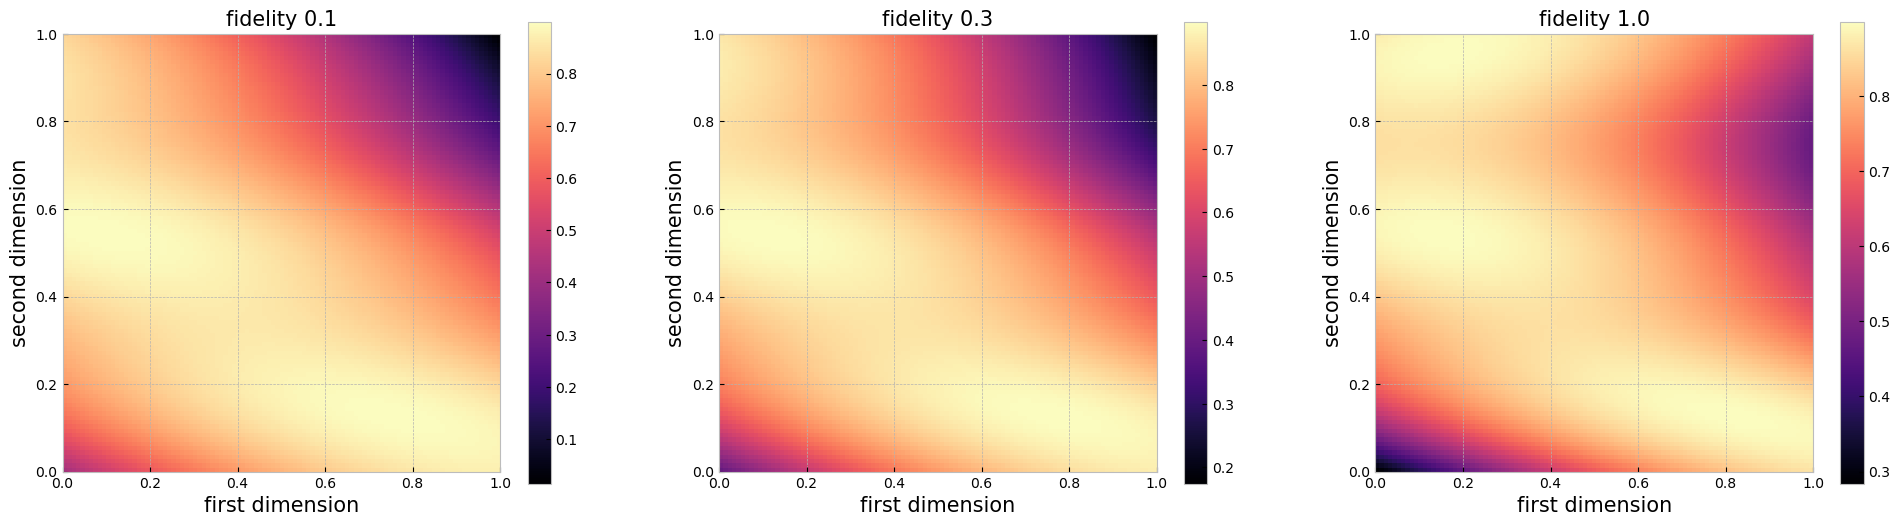

In [3]:
def visualize_objective(f):
    grid_x = torch.linspace(0, 1, 101)
    grid_x1, grid_x2 = torch.meshgrid(grid_x, grid_x, indexing="ij")
    grid_x1 = grid_x1.flatten()
    grid_x2 = grid_x2.flatten()

    fig, ax = plt.subplots(1, 3, figsize=(8 * fidelities.numel(), 6))

    for ax_ind in range(fidelities.numel()):
        tmp_ax = ax[ax_ind]

        xs = torch.zeros(101 ** 2, 3)
        xs[:, 0] = grid_x1
        xs[:, 1] = grid_x2
        xs[:, 2] = fidelities[ax_ind]

        c = tmp_ax.imshow(
            f(xs).reshape(101, 101),
            origin="lower",
            extent=[0, 1, 0, 1],
        )
        plt.colorbar(c, ax=tmp_ax)

        tmp_ax.set_xlabel("first dimension", fontsize=15)
        tmp_ax.set_ylabel(f"second dimension", fontsize=15)

        tmp_ax.set_title(f"fidelity {fidelities[ax_ind]:.1f}", fontsize=15)

    plt.show()


visualize_objective(objective)

In [4]:
from botorch.models.gp_regression_fidelity import SingleTaskMultiFidelityGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll

from botorch.models.cost import AffineFidelityCostModel
from botorch.acquisition.cost_aware import InverseCostWeightedUtility
from botorch.acquisition.fixed_feature import FixedFeatureAcquisitionFunction
from botorch.acquisition.max_value_entropy_search import (
    qMaxValueEntropy,
    qMultiFidelityMaxValueEntropy,
)
from torch.quasirandom import SobolEngine
from botorch.acquisition.utils import project_to_target_fidelity


num_samples = 5000  # sobol samples
# optimize_acqf arguments
num_restarts = 100
raw_samples = 500

cost_model = AffineFidelityCostModel(fixed_cost=0.2)
cost_aware_utility = InverseCostWeightedUtility(cost_model=cost_model)

In [5]:
from botorch.acquisition.fixed_feature import FixedFeatureAcquisitionFunction
from botorch.acquisition import PosteriorMean
from botorch.optim.optimize import optimize_acqf, optimize_acqf_mixed


def get_final_recommendation(model):
    post_mean_policy = FixedFeatureAcquisitionFunction(
        acq_function=PosteriorMean(model),
        d=3,
        columns=[2],
        values=[1],
    )

    final_x, _ = optimize_acqf(
        post_mean_policy,
        bounds=bounds,
        q=1,
        num_restarts=num_restarts,
        raw_samples=raw_samples,
    )

    return torch.cat([final_x, torch.ones(1, 1)], dim=1)

In [6]:
budget_limit = 10
num_repeats = 10

In [7]:
class ignore_warnings:
    def __enter__(self):
        warnings.filterwarnings("ignore", category=InputDataWarning)
        warnings.filterwarnings("ignore", category=UserWarning)
        warnings.filterwarnings("ignore", category=OptimizationWarning)
        warnings.filterwarnings("ignore", category=RuntimeWarning)

    def __exit__(self, exc_type, exc_value, traceback):
        warnings.resetwarnings()

In [8]:
strategy = "mes"  # "mfmes" or "mes"
strategy = strategy.upper()

recommendations = []
spent_budget = []

for trial in range(num_repeats):
    print("trial", trial)

    torch.manual_seed(trial)
    train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(1, 2)
    train_x = torch.cat(
        [train_x, torch.ones(train_x.shape[-2], 1) * fidelities[0]], dim=1
    )

    train_y = objective(train_x)

    current_budget = 0
    recommendations.append([])
    spent_budget.append([])

    print("current budget:", end=" ")
    while current_budget < budget_limit:
        print(f"{current_budget:.2f}", end=" ")

        # train the GP
        with ignore_warnings():
            model = SingleTaskMultiFidelityGP(train_x, train_y, data_fidelity=2)
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            fit_gpytorch_mll(mll)

        # get recommendataion based on the current model
        with ignore_warnings():
            rec_x = get_final_recommendation(model)
        recommendations[-1].append(objective(rec_x).item())
        spent_budget[-1].append(current_budget)

        sobol = SobolEngine(2, scramble=True)
        candidate_x = sobol.draw(num_samples)
        candidate_x = bounds[0] + (bounds[1] - bounds[0]) * candidate_x
        candidate_x = torch.cat([candidate_x, torch.ones(num_samples, 1)], dim=1)

        if strategy == "MES":
            policy = FixedFeatureAcquisitionFunction(
                acq_function=qMaxValueEntropy(model, candidate_x, num_fantasies=128),
                d=3,
                columns=[2],
                values=[1],
            )
            
            with ignore_warnings():
                next_x, acq_val = optimize_acqf(
                    policy,
                    bounds=bounds,
                    q=1,
                    num_restarts=num_restarts,
                    raw_samples=raw_samples,
                )

            next_x = torch.cat([next_x, torch.ones(1, 1)], dim=1)

        if strategy == "MFMES":
            policy = qMultiFidelityMaxValueEntropy(
                model,
                candidate_x,
                num_fantasies=128,
                cost_aware_utility=cost_aware_utility,
                project=project_to_target_fidelity,
            )
            
            with ignore_warnings():
                next_x, acq_val = optimize_acqf_mixed(
                    policy,
                    bounds=bounds_full,
                    fixed_features_list=[{2: cost.item()} for cost in fidelities],
                    q=1,
                    num_restarts=num_restarts,
                    raw_samples=raw_samples,
                )

        next_y = objective(next_x)
        current_budget += cost_model(next_x).item()

        train_x = torch.cat([train_x, next_x])
        train_y = torch.cat([train_y, next_y])

    print()

trial 0
current budget: 0.00 1.20 2.40 3.60 4.80 6.00 7.20 8.40 9.60 
trial 1
current budget: 0.00 1.20 2.40 3.60 4.80 6.00 7.20 8.40 9.60 
trial 2
current budget: 0.00 1.20 2.40 3.60 4.80 6.00 7.20 8.40 9.60 
trial 3
current budget: 0.00 1.20 2.40 3.60 4.80 6.00 7.20 8.40 9.60 
trial 4
current budget: 0.00 1.20 2.40 3.60 4.80 6.00 7.20 8.40 9.60 
trial 5
current budget: 0.00 1.20 2.40 3.60 4.80 6.00 7.20 8.40 9.60 
trial 6
current budget: 0.00 1.20 2.40 3.60 4.80 6.00 7.20 8.40 9.60 
trial 7
current budget: 0.00 1.20 2.40 3.60 4.80 6.00 7.20 8.40 9.60 
trial 8
current budget: 0.00 1.20 2.40 3.60 4.80 6.00 7.20 8.40 9.60 
trial 9
current budget: 0.00 1.20 2.40 3.60 4.80 6.00 7.20 8.40 9.60 


In [9]:
with open(f"./branin/{strategy}.pkl", "wb") as f:
    pickle.dump([recommendations, spent_budget], f)

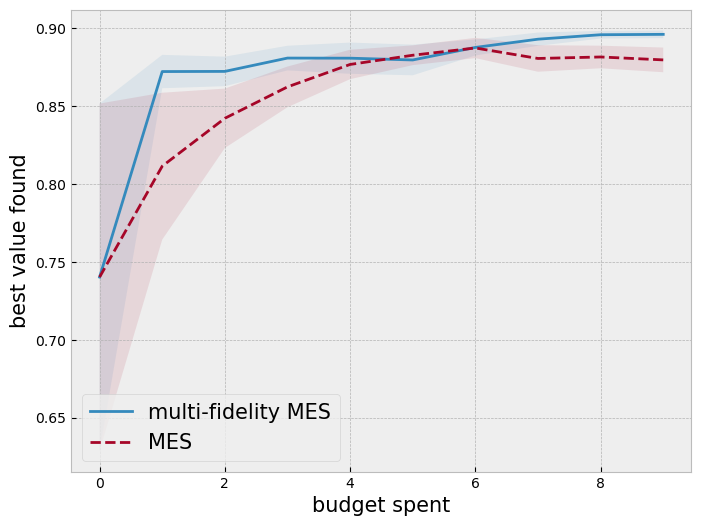

In [10]:
def process_and_show_progress(path, name, linestyle):
    def ci(y):
        return 2 * y.std(axis=0) / np.sqrt(num_repeats)

    with open(path, "rb") as f:
        incumbents, spent_budget = pickle.load(f)

    xs = np.arange(budget_limit)
    interp_incumbents = np.empty((num_repeats, budget_limit))

    for i, (tmp_incumbents, tmp_budget) in enumerate(zip(incumbents, spent_budget)):
        interp_incumbents[i, :] = np.interp(xs, tmp_budget, tmp_incumbents)

    avg_incumbent = interp_incumbents.mean(axis=0)
    ci_incumbent = ci(interp_incumbents)
    plt.plot(avg_incumbent, linestyle, label=name)
    plt.fill_between(
        xs,
        avg_incumbent + ci_incumbent,
        avg_incumbent - ci_incumbent,
        alpha=0.1,
    )


process_and_show_progress("./branin/MFMES.pkl", "multi-fidelity MES", "C0-")
process_and_show_progress("./branin/MES.pkl", "MES", "C1--")

plt.xlabel("budget spent", fontsize=15)
plt.ylabel("best value found", fontsize=15)

plt.legend(fontsize=15);